In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from model import UNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# load model and set to eval mode
model = UNet(n_channels=4, n_classes=1)
model.load_state_dict(torch.load("../ckpt/0.8142160177230835_1729589887.964992.pth", weights_only=False))
model.to(device=device, memory_format=torch.channels_last)
model.eval()
"ok"

'ok'

Path: datasets\BraTS2021_Training_Data\BraTS2021_00139, frame: 50
1


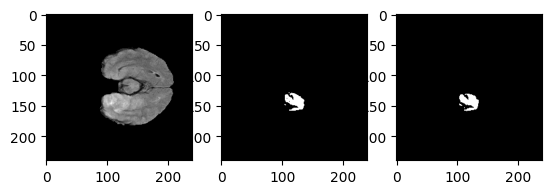

In [37]:
from datasets import get_data_path, load_data
THRESHOLD = 0.75
IMG_TYPE = ("flair", "t1", "t1ce", "t2")
DATA_DIR = "./datasets/BraTS2021_Training_Data"
PATH_ID = 100
KEY_FRAME = 50
# get test input & output
path = get_data_path(Path(DATA_DIR))[PATH_ID]
print(f"Path: {path}, frame: {KEY_FRAME}")
images = load_data(path, "img", KEY_FRAME)
true_mask = load_data(path, "mask", KEY_FRAME)
# glance at the input & true mask
ax = plt.subplot(1, 3, 1)
ax.imshow(images[0], cmap="gray")
ax = plt.subplot(1, 3, 2)
ax.imshow(true_mask, cmap="gray")
# preprocessing image into torch Tensor
images = np.asarray([images])
images = torch.as_tensor(images.copy()).float().contiguous()
images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
# inference
res = model(images)
pred_mask = res.cpu().squeeze().detach().numpy()
# # normalization
pred_mask = (pred_mask - pred_mask.min()) / (pred_mask.max() - pred_mask.min())
pred_mask = pred_mask > (THRESHOLD * pred_mask.max())
if pred_mask.sum() > 1000: pred_mask = np.zeros(pred_mask.shape)
ax = plt.subplot(1, 3, 3)
ax.imshow(pred_mask.astype(np.uint8) * 255, cmap="gray")
plt.show()